<a href="https://colab.research.google.com/github/ViniciusKanh/MaskDeepDetection/blob/main/DeepLearning_MaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

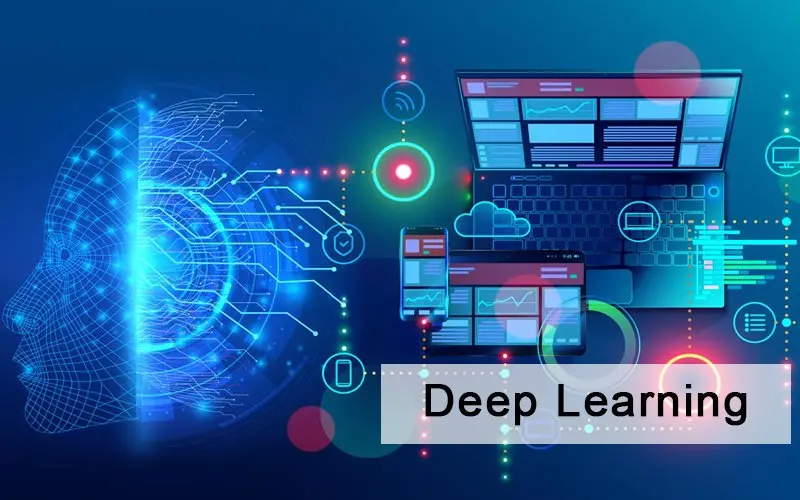
# Introdução
O CDC continua a monitorizar a propagação da COVID-19 e aconselha as pessoas que estão completamente vacinadas, bem como aquelas que não estão totalmente vacinadas, a usarem máscaras faciais. Ao visitar consultórios médicos, hospitais ou instituições de longa permanência, o CDC recomenda o uso de máscaras e a manutenção de uma distância segura.

Monitorar manualmente as pessoas que entram nessas instituições é tedioso e requer mão de obra. Neste tutorial aprenderemos como podemos automatizar esse processo por meio de técnicas de aprendizagem profunda que detectarão automaticamente pessoas que não usam máscaras para impedir sua entrada.

O Deep Learning: É um tipo de técnica de aprendizado de máquina que permite o aprendizado por meio do uso de redes neurais que imitam o cérebro humano.

Criando o modelo de aprendizagem profunda de detecção de máscara Vamos agora analisar a construção de um modelo de aprendizagem profunda para prever (detectar) se uma pessoa está violando as regras ao não usar máscara em espaços públicos.

# Etapa 1: importando as bibliotecas Python necessárias

In [1]:
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Caminho do arquivo ZIP no Google Drive
google_drive_path = '/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/FaceMaskDetection.zip'

# Caminho de destino no Colab
colab_destination = '/content/'

Mounted at /content/drive


In [2]:
# Descompactar o arquivo
import zipfile

with zipfile.ZipFile(google_drive_path, 'r') as zip_ref:
    zip_ref.extractall(colab_destination)

# Verificar os arquivos descompactados
import os

extracted_files = os.listdir(colab_destination)
print("Arquivos descompactados:")
print(extracted_files)

Arquivos descompactados:
['.config', 'annotations', 'images', 'drive', 'sample_data']


In [16]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Etapa 2: Obteção dos Dados

Obtendo os dados Para os dados de treinamento, estamos usando os dados de detecção de máscara facial daqui. O conjunto de dados contém 12 mil imagens divididas em conjuntos de teste, treinamento e validação que foram extraídos do Google e do conjunto de dados CelebFace criado por Jessica Li. Para começar a usá-lo, você pode baixar o conjunto de dados e salvá-lo no diretório de trabalho.

In [17]:
# Load train and test set
train_dir = "/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/Face Mask Dataset/Train"
test_dir = "/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/Face Mask Dataset/Test"
val_dir = "/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/Face Mask Dataset/Validation"

# Etapa 3: leitura das Imagens

ler uma imagem de amostra e realizar a detecção de rosto
Agora leremos uma imagem de exemplo de um aeroporto movimentado e realizaremos a detecção de rosto usando o classificador em cascata haar. O classificador em cascata Haar (https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html), originalmente conhecido como Técnica de Detecção de Rosto Viola-Jones, é um algoritmo de detecção de objetos para detectar rostos em imagens ou vídeos em tempo real.

Viola e Jones propuseram recursos de detecção de bordas ou linhas em seu artigo de pesquisa "Rapid Object Detection using a Boosted Cascade of Simple Features", publicado em 2001. O algoritmo recebe um grande número de fotos positivas com rostos e um grande número de imagens negativas com sem rostos. O modelo desenvolvido como resultado deste treinamento pode ser encontrado no repositório OpenCV GitHub.

Referencias: Viola, Paul, and Michael Jones. "Rapid object detection using a boosted cascade of simple features." Proceedings of the 2001 IEEE computer society conference on computer vision and pattern recognition. CVPR 2001. Vol. 1. Ieee, 2001.

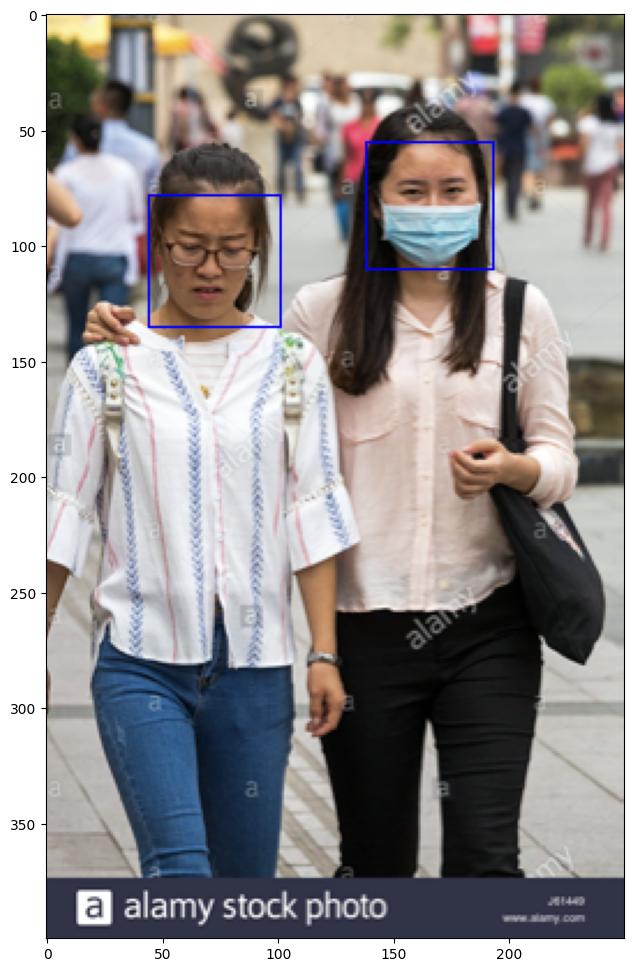

In [18]:
# Read a sample image
img = cv2.imread("/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/images/maksssksksss352.png")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image


Step 4: Data preprocessing for building the mask detection Keras model
We will now pass our datasets into Keras ImageDataGenerator() to perform some preliminary data augmentation steps such as rescaling.

In [19]:
# Data preprocessing
# Train data
#CNN Algorithm
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Etapa 5: Crie o modelo de aprendizagem por transferência de detecção de máscara usando Keras Estamos construindo o classificador de aprendizagem profunda usando o modelo de aprendizagem por transferência VGG19. O modelo VGG19 é o sucessor do AlexNet, uma variação do modelo VGG que leva o nome do grupo denominado Visual Geometry Group em Oxford que o criou. É uma CNN profunda que consiste em 19 camadas (16 camadas de convolução, 3 camadas totalmente conectadas, 5 camadas MaxPool e 1 camada SoftMax) usadas para classificar imagens.

Foi treinado no ImageNet, um banco de dados de imagens com 14.197.122 imagens estruturadas de acordo com a hierarquia do WordNet.



In [22]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20040770 (76.45 MB)
Trainable params: 16386 (64.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


Passo 6: Treine o modelo¶
Agora treinaremos nosso modelo de rede neural por 20 épocas.

In [24]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

<ipython-input-24-71cc3d49c955>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/20
9/9 [==============================] - 71s 8s/step - loss: 0.4151 - accuracy: 0.7951
Epoch 2/20
9/9 [==============================] - 69s 7s/step - loss: 0.1731 - accuracy: 0.9410
Epoch 3/20
9/9 [==============================] - 69s 8s/step - loss: 0.1499 - accuracy: 0.9479
Epoch 4/20
9/9 [==============================] - 68s 8s/step - loss: 0.1104 - accuracy: 0.9618
Epoch 5/20
9/9 [==============================] - 68s 7s/step - loss: 0.1043 - accuracy: 0.9583
Epoch 6/20
9/9 [==============================] - 67s 8s/step - loss: 0.1153 - accuracy: 0.9618
Epoch 7/20
9/9 [==============================] - 68s 7s/step - loss: 0.0936 - accuracy: 0.9688
Epoch 8/20
9/9 [==============================] - 66s 7s/step - loss: 0.0838 - accuracy: 0.9757
Epoch 9/20
9/9 [==============================] - 69s 8s/step - loss: 0.0862 - accuracy: 0.9653
Epoch 10/20
9/9 [==============================] - 73s 7s/step - loss: 0.0833 - accuracy: 0.9757
Epoch 11/20
9/9 [======================

Etapa 7: avaliar o desempenho do modelo no conjunto de testes

In [26]:
# Evaluate model performance on test data Using CNN
model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

25/25 [==============================] - 205s 8s/step - loss: 0.0523 - accuracy: 0.9850
Model has a loss of 0.05 and accuracy 98.50%


Step 8: Save the model
We can also choose to save the trained model as a h5 file for future use.

In [27]:
model.save('/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/saved_model.h5')


Etapa 7: teste o modelo na imagem de amostra
Agora testaremos o modelo treinado em nosso caso de uso para detecção de rostos e máscaras para um grupo de pessoas. Pegamos os cortes de rostos detectados dos rostos detectados na imagem e então prevemos a máscara ou nenhuma máscara usando o modelo treinado.

1/1 [==============================] - 0s 222ms/step


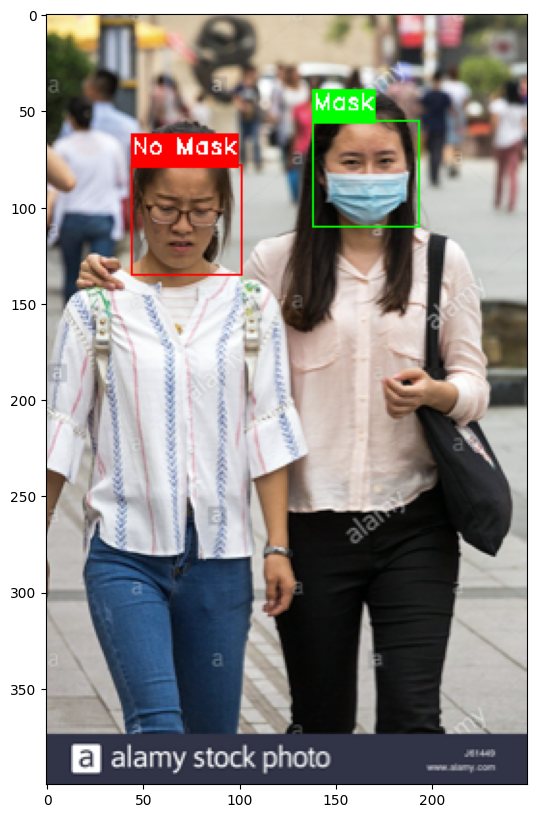

In [28]:
import tensorflow as tf

# Carregue o modelo pré-treinado de detecção de máscara
model = tf.keras.models.load_model('/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/saved_model.h5')

# label for mask detection
mask_det_label = {0: "Mask", 1: "No Mask"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size

    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  # draw rectangle

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image

Testando o modelo nos dados de teste

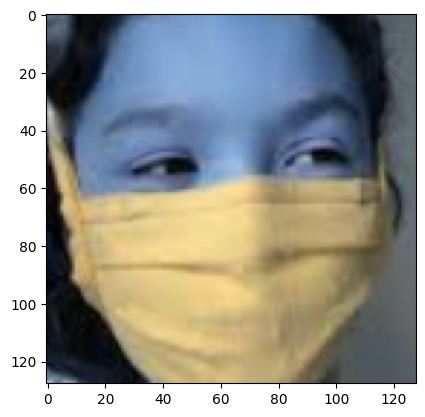

In [29]:
sample_mask_img = cv2.imread('/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

FileUpload(value={}, description='Upload')

1/1 [==============================] - 0s 436ms/step


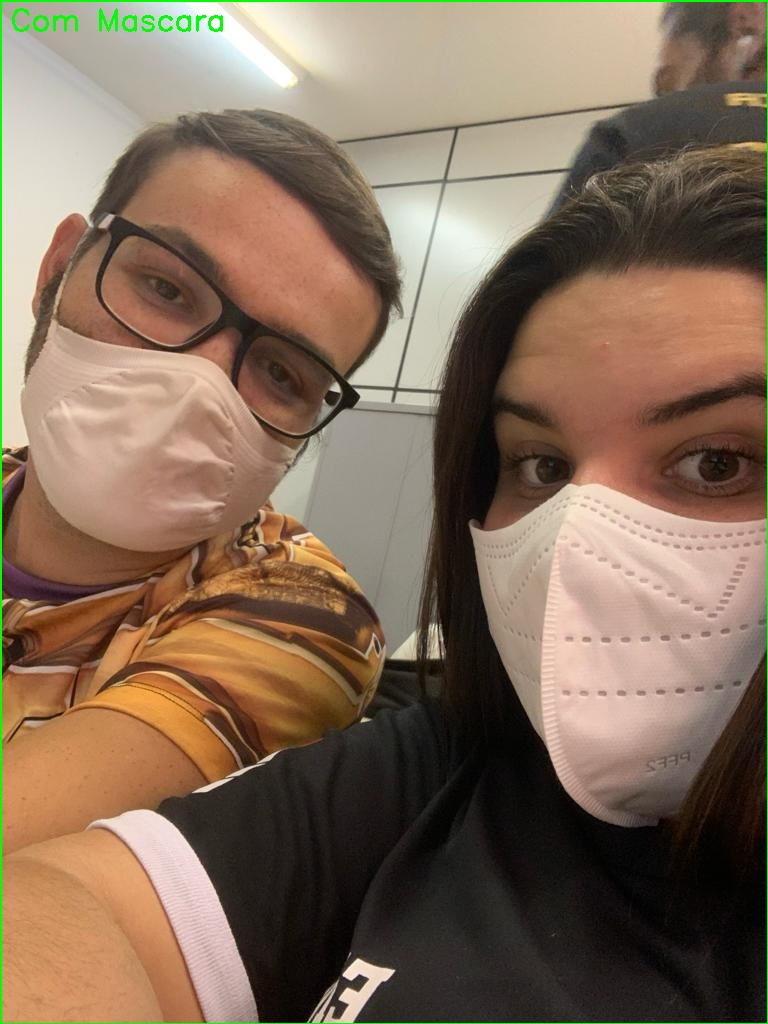

1/1 [==============================] - 0s 226ms/step


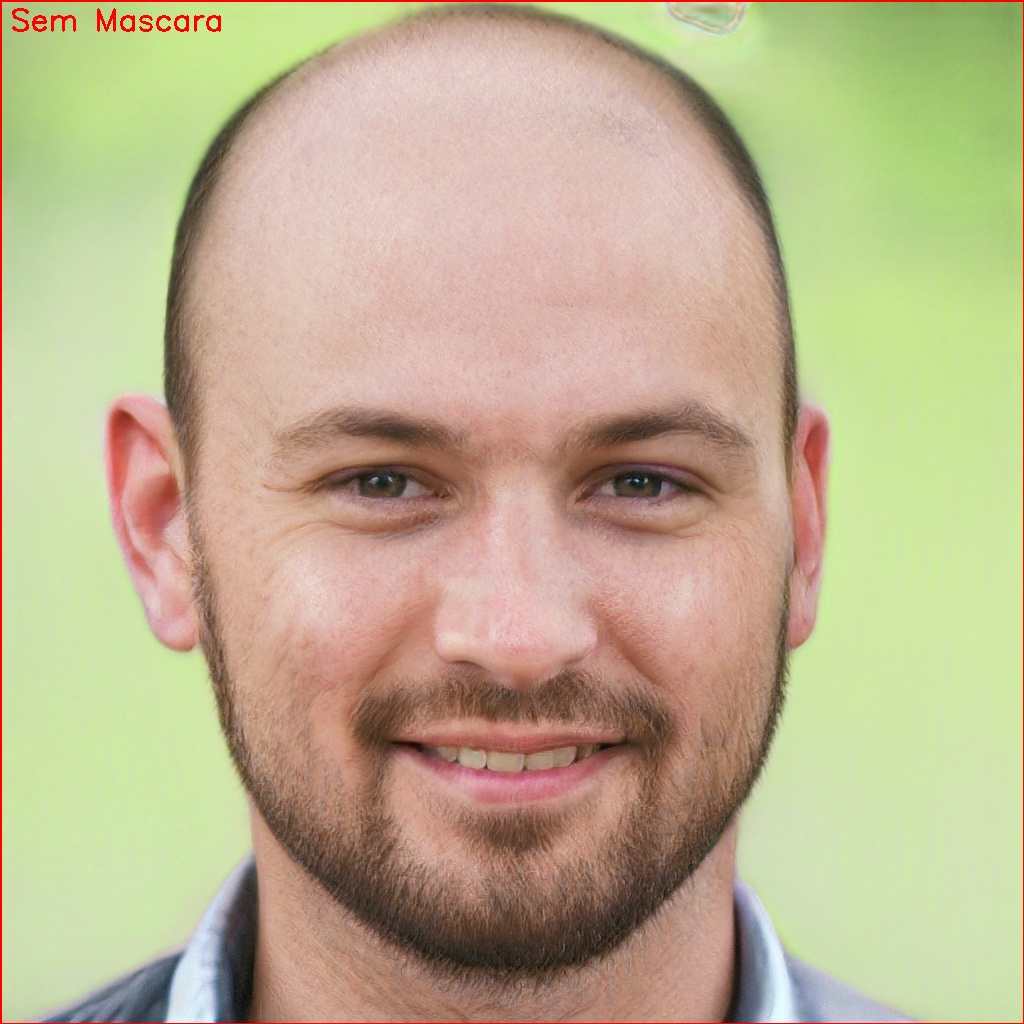

1/1 [==============================] - 0s 316ms/step


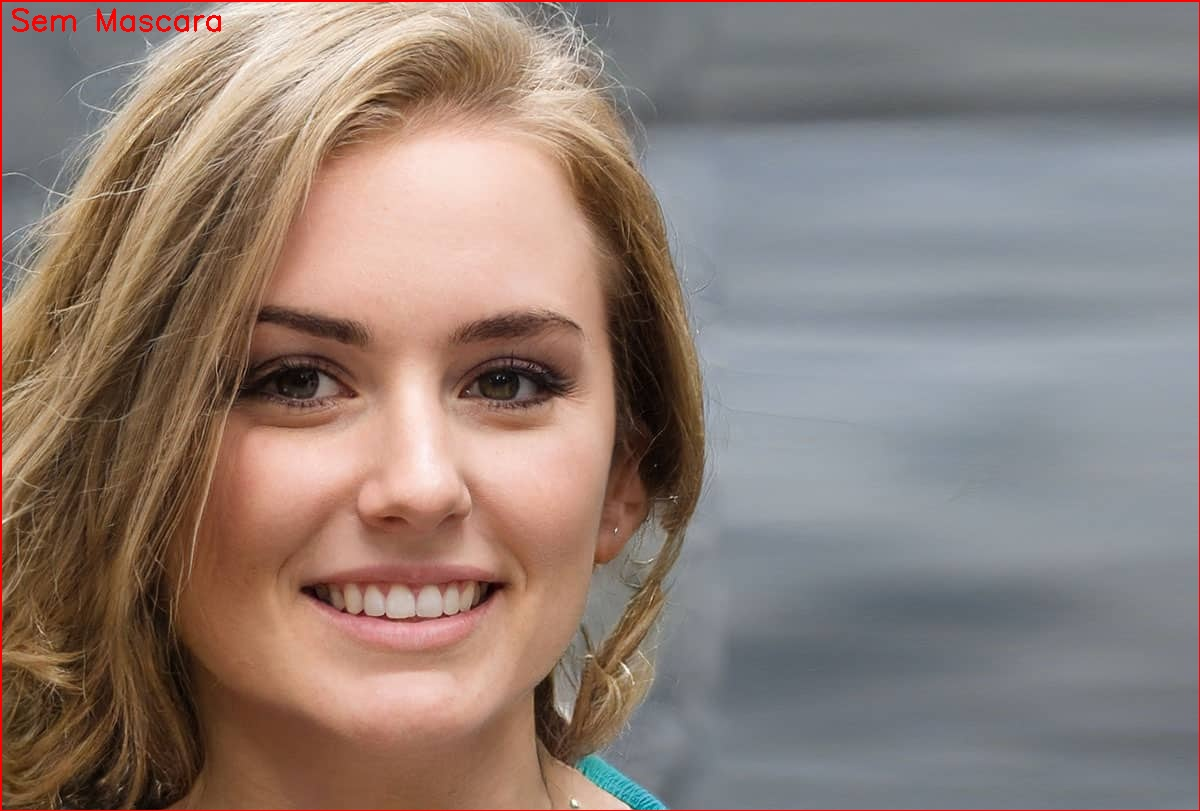

1/1 [==============================] - 0s 230ms/step


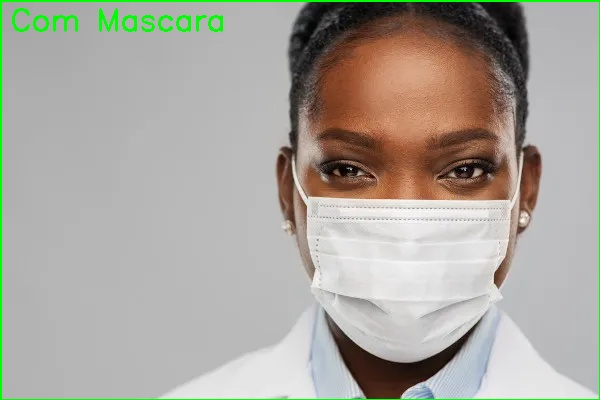

In [33]:
import cv2
import numpy as np
from ipywidgets import FileUpload
from IPython.display import display, Image
import tensorflow as tf

# Carregue o modelo pré-treinado de detecção de máscara
model = tf.keras.models.load_model('/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/saved_model.h5')


# Função para fazer a predição de máscara
def predict_mask(change):
    uploaded_file = list(upload_btn.value.values())[0]
    content = uploaded_file['content']
    image = np.frombuffer(content, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_copy = image.copy()  # Crie uma cópia da imagem para desenhar retângulos

    image = cv2.resize(image, (128, 128))  # Redimensione a imagem para o tamanho esperado pelo modelo
    image = image / 255.0  # Normalize a imagem

    prediction = model.predict(np.expand_dims(image, axis=0))
    if prediction[0][0] > 0.5:
        label = "Com Mascara"
        color = (0, 255, 0)  # Verde para com máscara
    else:
        label = "Sem Mascara"
        color = (255, 0, 0)  # Vermelho para sem máscara

    # Desenhe um retângulo com a marcação na imagem
    cv2.rectangle(image_copy, (0, 0), (image_copy.shape[1], image_copy.shape[0]), color, 2)
    cv2.putText(image_copy, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Converta a imagem para o formato adequado para ser exibida
    image_with_markings = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)

    # Exiba a imagem com as marcações
    display(Image(data=cv2.imencode('.jpg', image_with_markings)[1].tobytes()))

# Crie um botão de upload
upload_btn = FileUpload()
upload_btn.observe(predict_mask, names='_counter')

# Exiba o botão de upload
display(upload_btn)


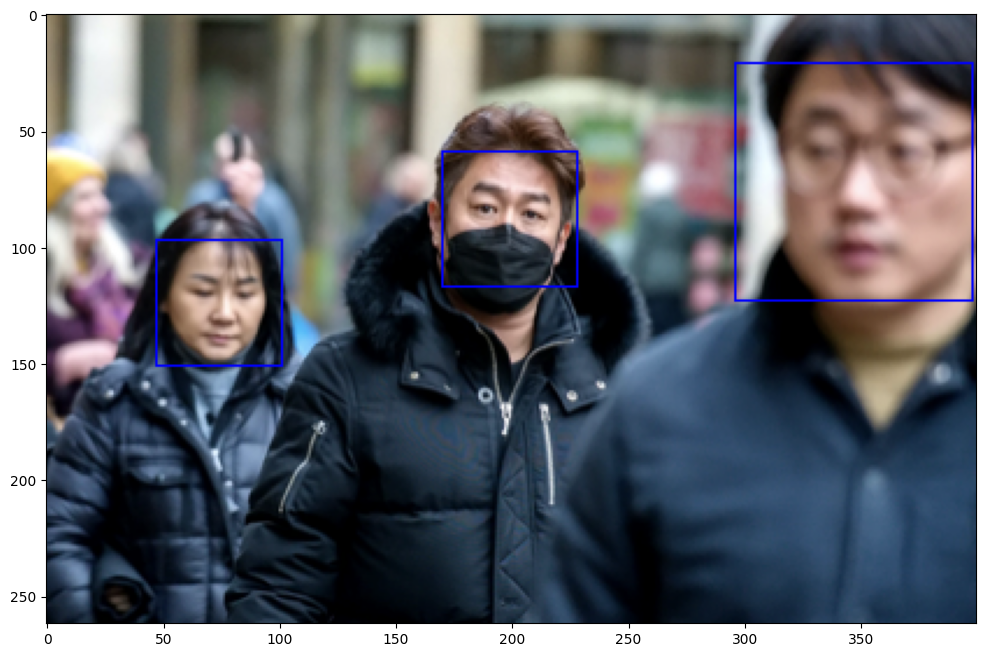

In [43]:
import cv2
import matplotlib.pyplot as plt

# Load a different Haar Cascade model for face detection
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Check if the model was loaded successfully
if face_model.empty():
    print("Error: Haar Cascade Classifier model not loaded.")
else:
    # Load the image with the updated path
    img = cv2.imread('/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/images/maksssksksss244.png')

    # Check if the image was loaded successfully
    if img is not None:
        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        faces = face_model.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=4)

        if len(faces) > 0:
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Colored output image

            # Drawing rectangles around detected faces
            for (x, y, w, h) in faces:
                cv2.rectangle(out_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

            # Display the image with rectangles
            plt.figure(figsize=(12, 12))
            plt.imshow(out_img)
            plt.show()
        else:
            print("No faces detected in the image.")
    else:
        print("Image not loaded. Check the image path.")


1/1 [==============================] - 0s 404ms/step


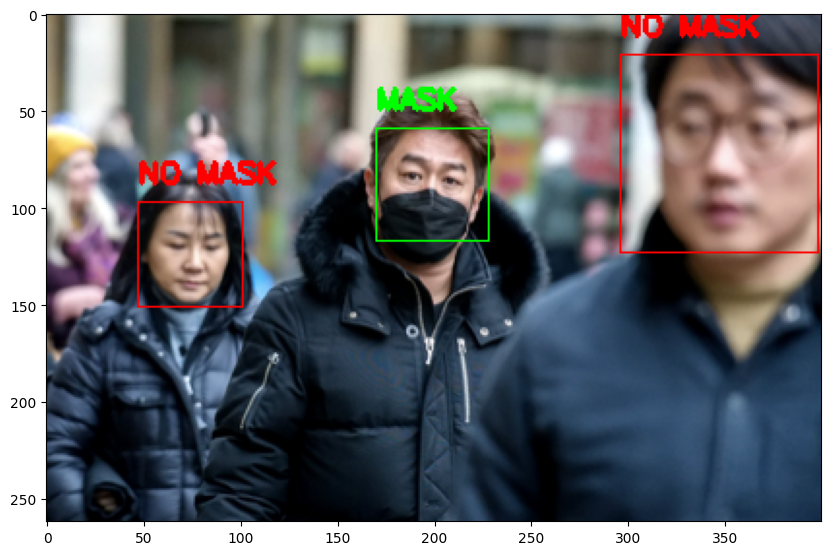

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Define a constant for minimum distance
MIN_DISTANCE = 50  # You can adjust this value as needed

# Load a different Haar Cascade model for face detection
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Check if the model was loaded successfully
if face_model.empty():
    print("Error: Haar Cascade Classifier model not loaded.")
else:
    # Load the image with the updated path
    img = cv2.imread('/content/drive/My Drive/Faculdade/Aula/2023.2/Processamento Digital de Imagem/Projeto_Reconhecimento_Objetos/MaskDetection/images/maksssksksss244.png')

    # Check if the image was loaded successfully
    if img is not None:
        # Convert the image to grayscale
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale image
        faces = face_model.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=4)

        mask_label = {0: 'MASK', 1: 'NO MASK'}
        dist_label = {0: (0, 255, 0), 1: (255, 0, 0)}

        if len(faces) >= 2:
            label = [0 for i in range(len(faces))]
            for i in range(len(faces) - 1):
                for j in range(i + 1, len(faces)):
                    dist = distance.euclidean(faces[i][:2], faces[j][:2])
                    if dist < MIN_DISTANCE:
                        label[i] = 1
                        label[j] = 1

            new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Colored output image
            for i in range(len(faces)):
                (x, y, w, h) = faces[i]
                crop = new_img[y:y + h, x:x + w]
                crop = cv2.resize(crop, (128, 128))
                crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
                # Assuming you have a model for mask detection
                mask_result = model.predict(crop)
                # Determine the color based on the label (mask or no mask)
                color = dist_label[label[i]]
                if mask_result.argmax() == 1:  # If it's "NO MASK"
                    color = (255, 0, 0)  # Set color to red
                cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                cv2.rectangle(new_img, (x, y), (x + w, y + h), color, 1)

            plt.figure(figsize=(10, 10))
            plt.imshow(new_img)
        else:
            print("No. of faces detected is less than 2")
    else:
        print("Image not loaded. Check the image path.")


In [54]:
!pip install mtcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.7 MB/s eta 0:00:00


In [55]:
from mtcnn.mtcnn import MTCNN

# Create an MTCNN detector
face_model = MTCNN()

# Detect faces using MTCNN
faces = face_model.detect_faces(img)

1/1 [==============================] - 0s 215ms/step


FileUpload(value={}, accept='.png', description='Upload')

No. of faces detected is less than 2
1/1 [==============================] - 0s 363ms/step


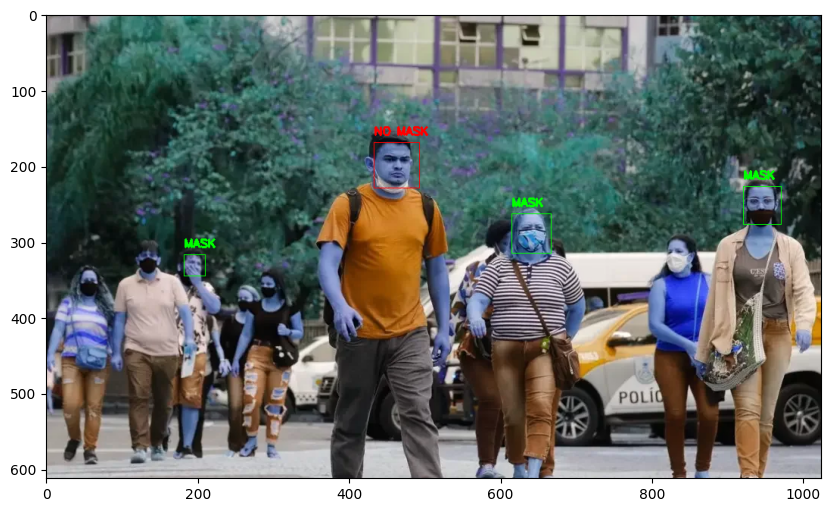

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from ipywidgets import FileUpload
from IPython.display import display
import io
from PIL import Image

# Define a constant for minimum distance
MIN_DISTANCE = 50  # You can adjust this value as needed

# Create a widget for file upload
upload = FileUpload(accept='.png', multiple=False)

# Display the upload widget
display(upload)

# Function to process the uploaded image
def process_uploaded_image(change):
    uploaded_filename = next(iter(upload.value))
    content = upload.value[uploaded_filename]['content']
    img = Image.open(io.BytesIO(content))
    img = np.array(img)

    if img is not None:
        # Load a Haar Cascade model for face detection
        face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        if face_model.empty():
            print("Error: Haar Cascade Classifier model not loaded.")
        else:
            # Convert the image to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect faces in the grayscale image
            faces = face_model.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=4)

            mask_label = {0: 'MASK', 1: 'NO MASK'}
            dist_label = {0: (0, 255, 0), 1: (255, 0, 0)}

            if len(faces) >= 2:
                label = [0 for i in range(len(faces))]
                for i in range(len(faces) - 1):
                    for j in range(i + 1, len(faces)):
                        dist = distance.euclidean(faces[i][:2], faces[j][:2])
                        if dist < MIN_DISTANCE:
                            label[i] = 1
                            label[j] = 1

                new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Colored output image
                for i in range(len(faces)):
                    (x, y, w, h) = faces[i]
                    crop = new_img[y:y + h, x:x + w]
                    crop = cv2.resize(crop, (128, 128))
                    crop = np.reshape(crop, [1, 128, 128, 3]) / 255.0
                    # Assuming you have a model for mask detection
                    mask_result = model.predict(crop)
                    # Determine the color based on the label (mask or no mask)
                    color = dist_label[label[i]]
                    if mask_result.argmax() == 1:  # If it's "NO MASK"
                        color = (255, 0, 0)  # Set color to red
                    cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                    cv2.rectangle(new_img, (x, y), (x + w, y + h), color, 1)

                plt.figure(figsize=(10, 10))
                plt.imshow(new_img)
            else:
                print("No. of faces detected is less than 2")
    else:
        print("Failed to decode the uploaded image.")

upload.observe(process_uploaded_image, names='value')
